In [31]:
import numpy as np

In [32]:
def bsm_mcs_valuation(strike):
    """
    Dynamic Black-Scholes-Merton Monte Carlo estimator
    for European calls.
    Parameters
    ==========
    strike : float
        strike price of the option
    Results
    =======
    value : float
        estimate for present value of call option
    """
    S0 = 100.; T = 1.0; r = 0.05; vola = 0.2
    M = 50; I = 20000
    dt = T / M
    rand = np.random.standard_normal((M+1, I))
    S = np.zeros((M + 1, I)); S[0] = S0
    for t in range(1, M + 1):
        S[t] = S[t-1] * np.exp((r - 0.5 * vola ** 2) * dt + vola * np.sqrt(dt) * rand[t])
    value = (np.exp(-r * T) * np.sum(np.maximum(S[-1] - strike, 0)) / I)
    return value

In [33]:
def seq_value(n):
    """
    Sequential option valuation.
    Parameters
    ==========
    n : int
        number of option valuations/strikes
    """
    strikes = np.linspace(80, 120, n)
    option_values = []
    for strike in strikes:
        option_values.append(bsm_mcs_valuation(strike))
    return strikes, option_values

In [34]:
n = 100  # number of options to be valued
%time strikes, option_values_seq = seq_value(n)

CPU times: user 6.44 s, sys: 373 ms, total: 6.81 s
Wall time: 6.94 s


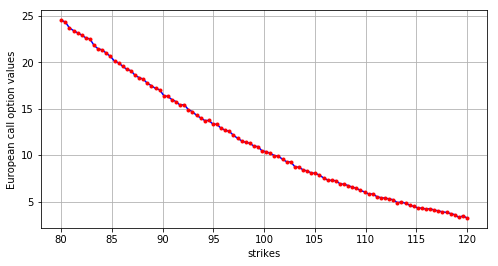

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(8, 4))
plt.plot(strikes, option_values_seq, 'b')
plt.plot(strikes, option_values_seq, 'r.')
plt.grid(True)
plt.xlabel('strikes')
plt.ylabel('European call option values')

In [37]:
# model & option parameter
S0 = 100.  # initial index level
T = 1.  # call option maturity
r = 0.05  # constant short rate
vola = 0.20  # constant volatility factor of diffusion
# time parameters
M = 1000 # time steps
dt=T/M #lengthoftimeinterval
df = np.exp(-r * dt) # discount factor per time interval
# binomial parameters
u = np.exp(vola * np.sqrt(dt)) # up-movement
d = 1 / u # down-movement
q = (np.exp(r * dt) - d) / (u - d) # martingale probability

In [38]:
def binomial_py(strike):
    """Binomial option pricing via looping.
    Parameters
    ==========
    strike : float
        strike price of the European call option
    """
    # LOOP 1 - Index Levels
    S = np.zeros((M + 1, M + 1), dtype=np.float64)
    # index level array
    S[0, 0] = S0
    z1 = 0
    for j in xrange(1, M + 1, 1):
        z1 = z1 + 1
        for i in xrange(z1 + 1):
            S[i, j] = S[0, 0] * (u ** j) * (d ** (i * 2))
    # LOOP 2 - Inner Values
    iv = np.zeros((M + 1, M + 1), dtype=np.float64)
    # inner value array
    z2 = 0
    for j in xrange(0, M + 1, 1):
        for i in xrange(z2 + 1):
            iv[i, j] = max(S[i, j] - strike, 0)
        z2 = z2 + 1
    # LOOP 3 - Valuation
    pv = np.zeros((M + 1, M + 1), dtype=np.float64)
    # present value array
    pv[:, M] = iv[:, M]  # initialize last time point
    z3 = M + 1
    for j in xrange(M - 1, -1, -1):
        z3 = z3 - 1
        for i in xrange(z3):
            pv[i, j] = (q * pv[i, j + 1] + (1 - q) * pv[i + 1, j + 1]) * df
    return pv[0, 0]

In [39]:
%time round(binomial_py(100), 3)

CPU times: user 2.78 s, sys: 106 ms, total: 2.88 s
Wall time: 2.86 s


10.449

In [40]:
%time round(bsm_mcs_valuation(100), 3)

CPU times: user 67.5 ms, sys: 3.85 ms, total: 71.4 ms
Wall time: 70.7 ms


10.489

In [44]:
def binomial_np(strike):
    """
    Binomial option pricing with NumPy.
    Parameters
    ==========
    strike : float
        strike price of the European call option
    """
    # Index Levels with NumPy
    mu = np.arange(M + 1)
    mu = np.resize(mu, (M + 1, M + 1))
    md = np.transpose(mu)
    mu = u ** (mu - md)
    md = d ** md
    S = S0 * mu * md
    # Valuation Loop
    pv = np.maximum(S - strike, 0)
    z=0
    for t in range(M - 1, -1, -1): # backward iteration
        pv[0:M - z, t] = (q * pv[0:M - z, t + 1] + (1 - q) * pv[1:M - z + 1, t + 1]) * df
        z += 1
    return pv[0, 0]

In [45]:
M = 4  # four time steps only
mu = np.arange(M + 1)
mu

array([0, 1, 2, 3, 4])

In [46]:
mu = np.resize(mu, (M + 1, M + 1))
mu

array([[0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4]])

In [47]:
md = np.transpose(mu)
md

array([[0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1],
       [2, 2, 2, 2, 2],
       [3, 3, 3, 3, 3],
       [4, 4, 4, 4, 4]])

In [49]:
mu = u ** (mu - md)   
mu.round(3)

array([[ 1.   ,  1.006,  1.013,  1.019,  1.026],
       [ 0.994,  1.   ,  1.006,  1.013,  1.019],
       [ 0.987,  0.994,  1.   ,  1.006,  1.013],
       [ 0.981,  0.987,  0.994,  1.   ,  1.006],
       [ 0.975,  0.981,  0.987,  0.994,  1.   ]])

In [50]:
md = d ** md
md.round(3)

array([[ 1.   ,  1.   ,  1.   ,  1.   ,  1.   ],
       [ 0.994,  0.994,  0.994,  0.994,  0.994],
       [ 0.987,  0.987,  0.987,  0.987,  0.987],
       [ 0.981,  0.981,  0.981,  0.981,  0.981],
       [ 0.975,  0.975,  0.975,  0.975,  0.975]])

In [51]:
S = S0 * mu * md
S.round(3)

array([[ 100.   ,  100.634,  101.273,  101.915,  102.562],
       [  98.743,   99.37 ,  100.   ,  100.634,  101.273],
       [  97.502,   98.121,   98.743,   99.37 ,  100.   ],
       [  96.276,   96.887,   97.502,   98.121,   98.743],
       [  95.066,   95.669,   96.276,   96.887,   97.502]])

In [52]:
M = 1000  # reset number of time steps
%time round(binomial_np(100), 3)

CPU times: user 162 ms, sys: 23.8 ms, total: 185 ms
Wall time: 186 ms


10.449

In [54]:
import numba as nb
binomial_nb = nb.jit(binomial_py)

In [55]:
%time round(binomial_nb(100), 3)

CPU times: user 820 ms, sys: 53.5 ms, total: 873 ms
Wall time: 925 ms


10.449

In [56]:
def perf_comp_data(func_list, data_list, rep=3, number=1):
    """Function to compare the performance of different functions.
       Parameters 
       ==========
       func_list : list
       list with function names as strings
       data_list : list
       list with data set names as strings
       rep : int
       number of repetitions of the whole comparison         
       number : int
       number of executions for every function
    """
    from timeit import repeat
    res_list = {}
    for name in enumerate(func_list):
        stmt = name[1] + '(' + data_list[name[0]] + ')'
        setup = "from __main__ import " + name[1] + ', ' + data_list[name[0]]
        results = repeat(stmt=stmt, setup=setup, repeat=rep, number=number)
        res_list[name[1]] = sum(results) / rep
    res_sort = sorted(res_list.iteritems(), key=lambda (k, v): (v, k))
    for item in res_sort:
        rel = item[1] / res_sort[0][1]
        print 'function: ' + item[0] + ', av. time sec: %9.5f, ' % item[1] + 'relative: %6.1f' % rel

In [57]:
func_list = ['binomial_py', 'binomial_np', 'binomial_nb']
K = 100.
data_list = 3 * ['K']

In [58]:
perf_comp_data(func_list, data_list)

function: binomial_np, av. time sec:   0.16247, relative:    1.0
function: binomial_nb, av. time sec:   0.22629, relative:    1.4
function: binomial_py, av. time sec:   2.50596, relative:   15.4


In [59]:
def f_py(I, J):
    res = 0.  # we work on a float object
    for i in range(I):
        for j in range (J * I):
            res += 1
    return res

In [60]:
I, J = 500, 500
%time f_py(I, J)

CPU times: user 26.2 s, sys: 706 ms, total: 26.9 s
Wall time: 26.8 s


125000000.0

In [63]:
import pyximport
pyximport.install()

(None, <pyximport.pyximport.PyxImporter at 0x113db7b50>)

In [64]:
import sys
sys.path.append('data/')
# path to the Cython script
# not needed if in same directory

In [65]:
from nested_loop import f_cy

In [66]:
%time res = f_cy(I, J)

CPU times: user 148 ms, sys: 811 µs, total: 149 ms
Wall time: 150 ms


In [67]:
res

125000000.0

In [70]:
%load_ext Cython

In [73]:
%%cython
# Nested loop example with Cython
def f_cy(int I, int J):
    cdef double res = 0
    # double float much slower than int or long
    for i in range(I):
        for j in range (J * I):
            res += 1
    return res

In [74]:
%time res = f_cy(I, J)

CPU times: user 144 ms, sys: 943 µs, total: 145 ms
Wall time: 146 ms


In [75]:
res

125000000.0

In [76]:
f_nb = nb.jit(f_py)

In [77]:
%time res = f_nb(I, J)

CPU times: user 273 ms, sys: 17.9 ms, total: 291 ms
Wall time: 287 ms


In [78]:
res

125000000.0

In [79]:
func_list = ['f_py', 'f_cy', 'f_nb']
I, J = 500, 500
data_list = 3 * ['I, J']

In [82]:
perf_comp_data(func_list, data_list)

function: f_nb, av. time sec:   0.14414, relative:    1.0
function: f_cy, av. time sec:   0.15652, relative:    1.1
function: f_py, av. time sec:  27.94806, relative:  193.9
